In [1]:
%matplotlib inline

from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from numpy.random import randint
from numpy import load
from numpy import zeros, ones, asarray
from sklearn.utils import resample
from random import random


C:\Users\user\anaconda3\envs\dl\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'


In [3]:
tf.config.experimental.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [4]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [5]:
dataset_name = "horse2zebra"
n_sample = 1000

In [6]:
def get_image_paths(path):
  data_list = []
  for filename in os.listdir(path):
    image_path = os.path.join(path, filename)
    data_list.append(image_path)
  return data_list

In [7]:
def generate_real_samples(path, n_samples=n_sample, patch_shape=16):
  image_paths = np.array(get_image_paths(path))
  indexes = randint(0, len(image_paths), n_samples)
  X = np.array([load_img_from_path(path) for path in image_paths[indexes]])
  y = ones((n_samples, patch_shape, patch_shape, 1))
  return X, y


In [8]:
def generate_fake_samples(g_model, dataset, patch_shape=16):
  X = g_model.predict(dataset)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

In [9]:
def load_img_from_path(image_path):
  pixels = load_img(image_path, target_size=(256, 256))
  pixels = img_to_array(pixels)
  pixels = pixels/127.5 - 1
  return pixels

In [10]:
def gen_dataset(n_sample=500):
  train_A_paths = get_image_paths(f"{dataset_name}/trainA")
  train_B_paths = get_image_paths(f"{dataset_name}/trainB")

  random_state = np.random.randint(0, 100)
  print("random_state", random_state)
  shuffle_indexes = resample(range(len(train_A_paths)), replace=False, n_samples=500, random_state=random_state)
  shuffled_trainA_img = (load_img_from_path(train_A_paths[index]) for index in shuffle_indexes)
  shuffled_trainB_img = (load_img_from_path(train_B_paths[index]) for index in shuffle_indexes)
  dataset = zip(shuffled_trainA_img, shuffled_trainB_img)
  return dataset


random_state 86


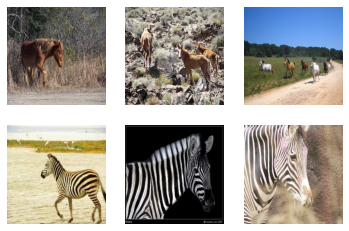

In [11]:
def check_dataset():
  dataset_ = gen_dataset()
  for i in range(3):
    img_A, img_B = next(dataset_)
    img_A = (img_A + 1) * 127.5
    img_B = (img_B + 1) * 127.5
    plt.subplot(2, 3, 1+i)
    plt.axis("off")
    plt.imshow(img_A.astype("uint8"))

    plt.subplot(2, 3, 4+i)
    plt.axis("off")
    plt.imshow(img_B.astype("uint8"))


check_dataset()


In [12]:
def resnet_block(n_filters, input_layer):
  init = RandomNormal(stddev=0.02)
  # as strides = 1, the shape is invariant
  g = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer=init)(input_layer)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation("relu")(g)
  g = Conv2D(n_filters, (3, 3), padding="same", kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Concatenate()([g, input_layer])
  return g

In [13]:
def define_discriminator(image_shape):
  init = RandomNormal(stddev=0.02)
  x = Input(shape=image_shape)
  d = Conv2D(64, (4, 4), strides=2, padding="same", kernel_initializer=init)(x)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(128, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(256, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4, 4), strides=(2, 2), padding="same", kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4, 4), padding="same", kernel_initializer=init)(d)
  d = InstanceNormalization(axis=-1)(d)
  d = LeakyReLU(alpha=0.2)(d)

  y = Conv2D(1, (4, 4), padding="same", kernel_initializer=init)(d)
  model = Model(x, y)
  return model


In [14]:
def define_generator(image_shape, n_resnet=9):
  init = RandomNormal(stddev=0.02)
  x = Input(shape=image_shape)
  g = Conv2D(64, (7, 7), padding="same", kernel_initializer=init)(x)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation("relu")(g)

  g = Conv2D(128, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation("relu")(g)

  g = Conv2D(256, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation("relu")(g)

  for _ in range(n_resnet):
    g = resnet_block(256, g)

  g = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation("relu")(g)

  g = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  g = Activation("relu")(g)

  g = Conv2D(3, (7, 7), padding="same", kernel_initializer=init)(g)
  g = InstanceNormalization(axis=-1)(g)
  y = Activation("tanh")(g)
  
  model = Model(x, y)

  return model


In [15]:
x = tf.random.normal([1, 256, 256, 3])
disc = define_discriminator((256, 256, 3))
print(tf.shape(disc(x)))

tf.Tensor([ 1 16 16  1], shape=(4,), dtype=int32)


In [16]:
dataset = gen_dataset()
img_A, img_B = next(dataset)
image_shape = img_A.shape
print("image_shape", image_shape)

random_state 44
image_shape (256, 256, 3)


In [17]:
def update_fake_img_pool(pool, images, max_size=50):
  selected = []
  for image in images:
    if len(pool) < max_size:
      # stock the pool
      pool.append(image)
      selected.append(image)
    elif random() < 0.5:
      # use image, but don't add it to the pool
      selected.append(image)
    else:
      # replace an existing image and use replaced image
      index = randint(0, len(pool))
      selected.append(pool[index])
      pool[index] = image
  
  return asarray(selected)


In [18]:
def update_fake_image_pool(pool, images, max_size=50):
  selected = []
  
  for image in images:
    if len(pool) < max_size:
      pool.append(image)
      selected.append(image)
    elif random() < 0.5:
      selected.append(image)
    else:
      # take one from the pool and and update the pool
      # the pool may contain new image that we never
      index = randint(0, len(pool))
      selected.append(pool[index])
      pool[index] = image
      
  return asarray(selected)

## Start Training

In [19]:
g_model_AtoB = define_generator(image_shape)
g_model_BtoA = define_generator(image_shape)
d_model_A = define_discriminator(image_shape)
d_model_B = define_discriminator(image_shape)

In [20]:
n_epochs, n_batch, = 100, 1
n_patch = d_model_A.output_shape[1]

batch_per_epoch = int(n_sample/n_epochs)
n_steps = batch_per_epoch * n_epochs

In [21]:

def show_result(step):
  dataset_ = gen_dataset()
  fig = plt.figure()
  fig.set_figheight(10)
  fig.set_figwidth(10)

  for i in range(3):
    img_A, _ = next(dataset_)
    fake_B = g_model_AtoB.predict(np.array([img_A]))
    cycle_A = g_model_BtoA.predict(fake_B)
    img_A = (img_A + 1) * 127.5
    fake_B = (fake_B[0] + 1) * 127.5
    cycle_A = (cycle_A[0] + 1) * 127.5

    plt.subplot(3, 3, 1+i)
    plt.axis("off")
    plt.imshow(img_A.astype("uint8"))

    plt.subplot(3, 3, 4+i)
    plt.axis("off")
    plt.imshow(fake_B.astype("uint8"))
    
    plt.subplot(3, 3, 7+i)
    plt.axis("off")
    plt.imshow(cycle_A.astype("uint8"))
    plt.savefig(f'result_{str(step).zfill(2)}.png')
    
  plt.show()


In [22]:
mse = MeanSquaredError()
mae = MeanAbsoluteError()

g_AB_opt = Adam(learning_rate=0.0002, beta_1 = 0.5)
g_BA_opt = Adam(learning_rate=0.0002, beta_1=0.5)

d_A_opt = Adam(learning_rate = 0.0002, beta_1 = 0.5)
d_B_opt = Adam(learning_rate=0.0002, beta_1=0.5)

poolA = list()
poolB = list()

for i in range(2000):
  shfted_index = i + 1
  print(f"step {shfted_index}", end="\r")
  if shfted_index % 10 == 0:
    show_result(shfted_index)

  X_realA, y_realA = generate_real_samples(f"./{dataset_name}/trainA", n_batch, n_patch)
  X_realB, y_realB = generate_real_samples(f"./{dataset_name}/trainB", n_batch, n_patch)
  X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
  X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
  
  X_fakeA = update_fake_img_pool(poolA, X_fakeA)
  X_fakeB = update_fake_img_pool(poolB, X_fakeB)
  
  
  X_realA = tf.convert_to_tensor(X_realA)
  y_realA = tf.convert_to_tensor(y_realA)
  X_realB = tf.convert_to_tensor(X_realB)
  y_realB = tf.convert_to_tensor(y_realB)
  X_fakeA = tf.convert_to_tensor(X_fakeA)
  y_fakeA = tf.convert_to_tensor(y_fakeA)
  X_fakeB = tf.convert_to_tensor(X_fakeB)
  y_fakeB = tf.convert_to_tensor(y_fakeB)
  
  with tf.GradientTape(persistent=True) as tape:
    fake_B = g_model_AtoB(X_realA, training=True)
    cycle_A = g_model_BtoA(fake_B, training=True)
    
    fake_A =  g_model_BtoA(X_realB, training=True)
    cycle_B = g_model_AtoB(fake_A, training =True)
    
    same_inB = g_model_AtoB(X_realB)
    same_inA = g_model_BtoA(X_realA)
    
    disc_real_A = d_model_A(X_realA)
    disc_fake_A = d_model_A(fake_A)
    
    disc_real_B = d_model_B(X_realB)
    disc_fake_B = d_model_B(fake_B)
    
    g_AtoB_loss = mse(y_realB, disc_fake_B)
    g_BtoA_loss = mse(y_realA, disc_fake_A)
    
    total_g_AtoB_loss = 5 * mae(X_realB, same_inB) + 10 * mae(X_realB, cycle_B) + g_AtoB_loss
    total_g_BtoA_loss = 5 * mae(X_realA, same_inA) + 10 * mae(X_realA, cycle_A) + g_BtoA_loss
    
    # train discriminator and generator separately:
    disc_B_loss = 0.5 * (mse(y_realB, disc_real_B) + mse(y_fakeB, disc_fake_B))
    disc_A_loss = 0.5 * (mse(y_realA, disc_real_A) + mse(y_fakeA, disc_fake_A))
   
  # derivatives
  grad_d_A = tape.gradient(disc_A_loss, d_model_A.trainable_variables)
  grad_d_B = tape.gradient(disc_B_loss, d_model_B.trainable_variables)
  
  grad_g_AtoB = tape.gradient(total_g_AtoB_loss, g_model_AtoB.trainable_variables)
  grad_g_BtoA = tape.gradient(total_g_BtoA_loss, g_model_BtoA.trainable_variables)
  
  # back-propagate
  d_A_opt.apply_gradients(zip(grad_d_A, d_model_A.trainable_variables))
  d_B_opt.apply_gradients(zip(grad_d_B, d_model_B.trainable_variables))
  
  g_AB_opt.apply_gradients(zip(grad_g_AtoB, g_model_AtoB.trainable_variables))
  g_BA_opt.apply_gradients(zip(grad_g_BtoA, g_model_BtoA.trainable_variables))
  


KeyboardInterrupt: 